In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc, roc_curve


In [20]:
def load_results(dataset: str, model: str, method: str):
    df_path = Path("../results") / dataset / f"{model}-large-{method}.jsonl"
    return pd.read_json(df_path, lines=True)

dataset = "webquestions"
model = "flipout"
base_path = Path("../results") / dataset / f"{model}-large.jsonl"
df = pd.read_json(base_path, lines=True)

for method in ("f1", "bertscore"):
    df[method] = load_results(dataset, model, method)[method].to_numpy()


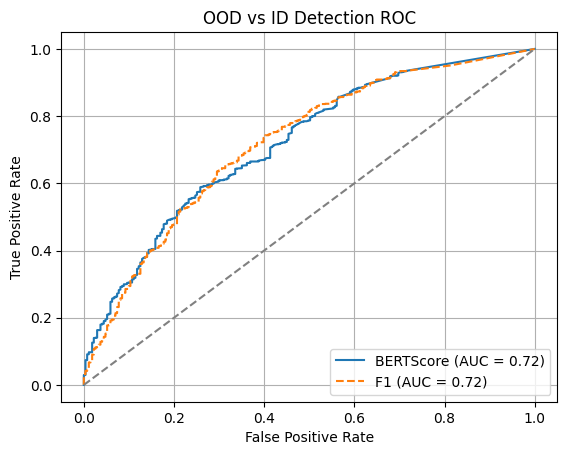

In [21]:
y_true  = (df["labels"] != "in").astype(int)

y_score1 = df["f1"]
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

y_score2 = df["bertscore"]
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

# plot both on one figure
plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--")

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


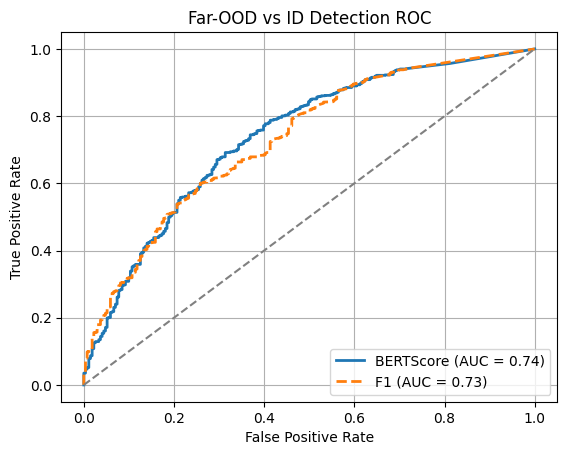

In [22]:
mask = df["labels"].isin(["in", "far-ood"])
y_true = (df.loc[mask, "labels"] == "far-ood").astype(int)

y_score1 = df.loc[mask, "bertscore"].to_numpy()
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

y_score2 = df.loc[mask, "f1"].to_numpy()
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})", linewidth=2)
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--", linewidth=2)

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Far-OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


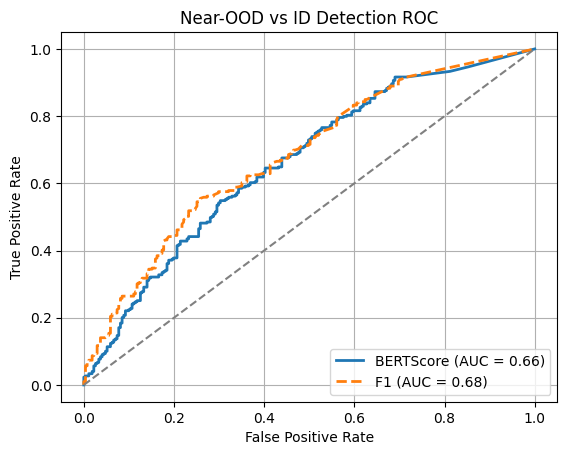

In [23]:
mask = df["labels"].isin(["in", "near-ood"])
y_true = (df.loc[mask, "labels"] == "near-ood").astype(int)

y_score1 = df.loc[mask, "bertscore"].to_numpy()
fpr1, tpr1, _ = roc_curve(y_true, y_score1)
roc_auc1     = auc(fpr1, tpr1)

y_score2 = df.loc[mask, "f1"].to_numpy()
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
roc_auc2     = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, label=f"BERTScore (AUC = {roc_auc1:.2f})", linewidth=2)
plt.plot(fpr2, tpr2, label=f"F1 (AUC = {roc_auc2:.2f})", linestyle="--", linewidth=2)

# chance line
plt.plot([0,1], [0,1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Near-OOD vs ID Detection ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [24]:
import re
import string
from collections import Counter

# source: https://github.com/facebookresearch/QA-Overlap/blob/main/evaluate.py
articles_pattern = re.compile(r"\b(a|an|the)\b")
def normalize_answer(s: str) -> str:
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text: str) -> str:
        return re.sub(articles_pattern, " ", text)

    def white_space_fix(text: str) -> str:
        return " ".join(text.split())

    def remove_punc(text: str) -> str:
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    return white_space_fix(remove_articles(remove_punc(str.lower(s))))

def most_frequent(lst: list[str]) -> str:
    filtered = [normalize_answer(s) for s in lst if s]
    return Counter(filtered).most_common(1)[0][0]


df["hard_pred"] = df["predictions"].apply(most_frequent)


print(df[df["labels"] == "in"].head())

                                             question  \
6                  what else did ben franklin invent?   
11  where is the fukushima daiichi nuclear plant l...   
12  who is the minority leader of the house of rep...   
22              what is the australian dollar called?   
23                           what timezone is sweden?   

                                              answers labels  \
6   [Lightning rod, Franklin stove, Bifocals, Glas...     in   
11                                     [Japan, Okuma]     in   
12                                     [Nancy Pelosi]     in   
22                                [Australian dollar]     in   
23                            [Central European Time]     in   

                                          predictions        f1  bertscore  \
6   [Lightning rod, Lightning rod, Lightning rod, ...  0.894427   0.464526   
11  [Japan, Japan, Japan, Japan, Japan, Japan, Jap...  0.358797   0.086847   
12  [Nancy Pelosi, Nancy Pelosi, Nancy

In [25]:
def is_exact_match(pred: str, golds: list[str]) -> bool:
    return any(pred == normalize_answer(gt) for gt in golds)

df["correct"] = df.apply(
    lambda r: is_exact_match(r["hard_pred"], r["answers"]),
    axis=1,
)

# per split EM score
print(100 * df.groupby("labels")["correct"].sum() / df.groupby("labels")["correct"].count())
print(df.groupby("labels")["correct"].sum())
print(df.groupby("labels")["correct"].count())

# overall EM score
print(100 * df["correct"].sum() / df["correct"].count())
print(df["correct"].sum())
print(df["correct"].count())

labels
far-ood      0.586166
in          60.516605
near-ood    15.384615
Name: correct, dtype: float64
labels
far-ood       5
in          164
near-ood     46
Name: correct, dtype: int64
labels
far-ood     853
in          271
near-ood    299
Name: correct, dtype: int64
15.10892480674631
215
1423
